In [2]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna
from sklearn.linear_model import Ridge


In [3]:
from lightgbm import LGBMRegressor

In [4]:
from pycaret.regression import*

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('submission.csv')

In [6]:
target = train['SalePrice']
test_ids = test['Id']

train1 = train.drop(['Id', 'SalePrice'], axis=1)
test1 = test.drop('Id', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)

In [7]:
data1

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2914         160       RM         21.0     1936   Pave   NaN      Reg   
2915         160       RM         21.0     1894   Pave   NaN      Reg   
2916          20       RL        160.0    20000   Pave   NaN      Reg   
2917          85       RL         62.0    10441   Pave   NaN      Reg   
2918          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
2            Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
3            Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
4            Lvl    AllPub       FR2  ...           0        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2914         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2918         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0       2    2008        WD         Normal  
1            NaN       0       5    2007        WD         Normal  
2            NaN       0       9    2008        WD         Normal  
3            NaN       0       2    2006        WD        Abnorml  
4            NaN       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2914         NaN       0       6    2006        WD         Normal  
2915         NaN       0       4    2006        WD        Abnorml  
2916         NaN       0       9    2006        WD        Abnorml  
2917        Shed     700       7    2006        WD         Normal  
2918         NaN       0      11    2006        WD         Normal  

[2919 rows x 79 columns]

In [8]:
data1['MSSubClass'] = data1['MSSubClass'].astype(str)

In [9]:
list(set(data1.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [10]:
data1.select_dtypes(include = ['O']).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
for column in data1.select_dtypes(include = ['O']).columns:
    data1[column] = data1[column].fillna("None")

# Impute using the column mode
for column in data1.select_dtypes(include = ['float64', 'int64']).columns:
    data1[column] = data1[column].fillna(data1[column].mean())

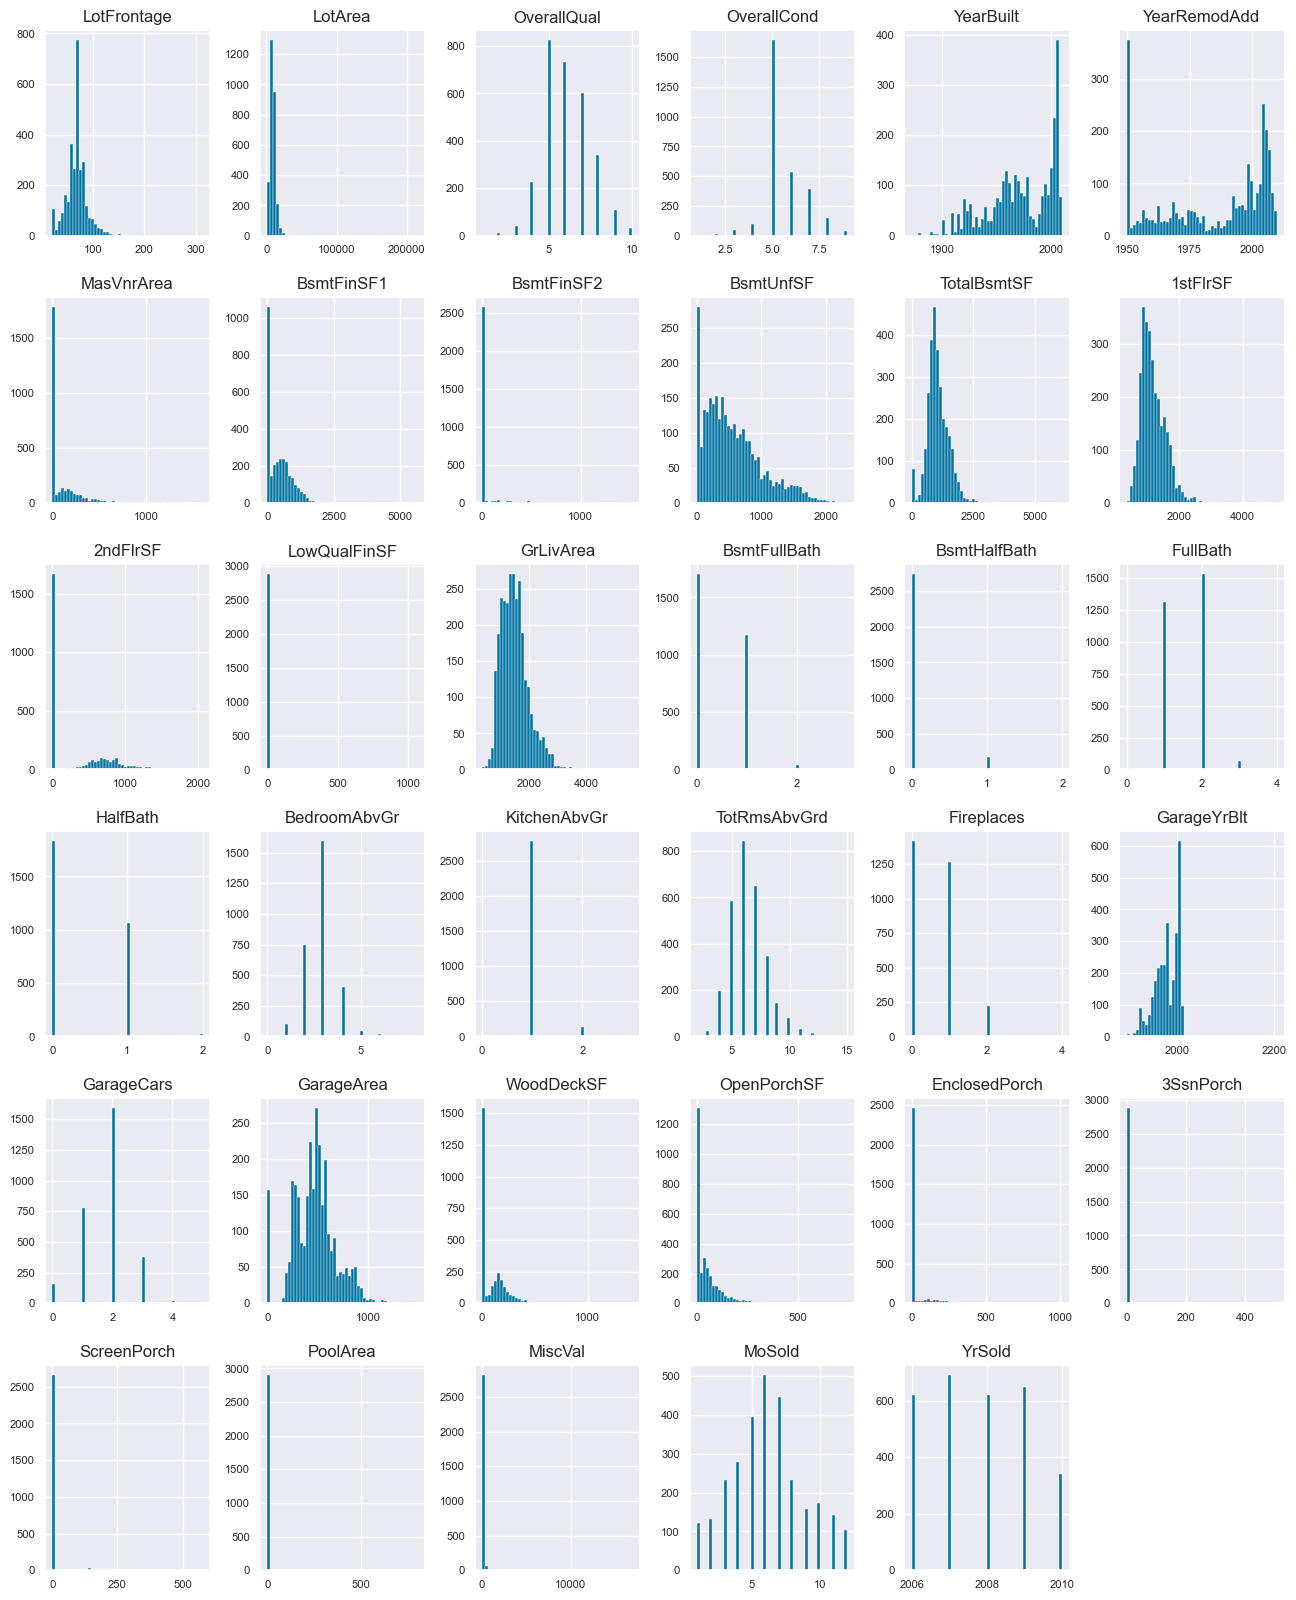

In [12]:
 data1.select_dtypes(include = ['float64', 'int64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


In [13]:
data2 = data1.copy()

In [14]:
data2["SqFtPerRoom"] = data2["GrLivArea"] / (data2["TotRmsAbvGrd"] +
                                                       data2["FullBath"] +
                                                       data2["HalfBath"] +
                                                       data2["KitchenAbvGr"])

data2['Total_Home_Quality'] = data2['OverallQual'] + data2['OverallCond']

data2['Total_Bathrooms'] = (data2['FullBath'] + (0.5 * data2['HalfBath']) +
                               data2['BsmtFullBath'] + (0.5 * data2['BsmtHalfBath']))

data2["HighQualSF"] = data2["1stFlrSF"] + data2["2ndFlrSF"]

In [15]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

Feature       Skew  Absolute Skew  Skewed
0          LotFrontage   1.645574       1.645574    True
1              LotArea  12.822431      12.822431    True
2          OverallQual   0.197110       0.197110   False
3          OverallCond   0.570312       0.570312    True
4            YearBuilt  -0.599806       0.599806    True
5         YearRemodAdd  -0.451020       0.451020   False
6           MasVnrArea   2.611549       2.611549    True
7           BsmtFinSF1   1.425233       1.425233    True
8           BsmtFinSF2   4.146034       4.146034    True
9            BsmtUnfSF   0.919508       0.919508    True
10         TotalBsmtSF   1.162484       1.162484    True
11            1stFlrSF   1.469604       1.469604    True
12            2ndFlrSF   0.861675       0.861675    True
13        LowQualFinSF  12.088761      12.088761    True
14           GrLivArea   1.269358       1.269358    True
15        BsmtFullBath   0.623955       0.623955    True
16        BsmtHalfBath   3.931343       3.931343    True
17            FullBath   0.167606       0.167606   False
18            HalfBath   0.694566       0.694566    True
19        BedroomAbvGr   0.326324       0.326324   False
20        KitchenAbvGr   4.302254       4.302254    True
21        TotRmsAbvGrd   0.758367       0.758367    True
22          Fireplaces   0.733495       0.733495    True
23         GarageYrBlt  -0.392790       0.392790   False
24          GarageCars  -0.218298       0.218298   False
25          GarageArea   0.241218       0.241218   False
26          WoodDeckSF   1.842433       1.842433    True
27         OpenPorchSF   2.535114       2.535114    True
28       EnclosedPorch   4.003891       4.003891    True
29           3SsnPorch  11.376065      11.376065    True
30         ScreenPorch   3.946694       3.946694    True
31            PoolArea  16.898328      16.898328    True
32             MiscVal  21.947195      21.947195    True
33              MoSold   0.195884       0.195884   False
34              YrSold   0.132399       0.132399   False
35         SqFtPerRoom   0.893992       0.893992    True
36  Total_Home_Quality  -0.564123       0.564123    True
37     Total_Bathrooms   0.493840       0.493840   False
38          HighQualSF   1.252036       1.252036    True

In [16]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data2[column] = np.log1p(data2[column])

In [17]:
data2['MoSold'] = (-np.cos(0.5236 * data2['MoSold']))

In [18]:
data3 = data2.copy()

In [19]:
data4 = pd.get_dummies(data3)

In [20]:
scaler = StandardScaler()
scaler.fit(data4)

data7 = pd.DataFrame(scaler.transform(data4), index=data4.index, columns=data4.columns)

In [21]:
data7

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       -0.049717 -0.103719     0.646183    -0.435439   1.040634   
1        0.588360  0.146544    -0.063185     1.906370   0.161526   
2        0.088781  0.457629     0.646183    -0.435439   0.975922   
3       -0.295173  0.136301     0.646183    -0.435439  -1.869638   
4        0.738543  0.922662     1.355551    -0.435439   0.943542   
...           ...       ...          ...          ...        ...   
2914    -3.472654 -2.993401    -1.481920     1.226101  -0.035461   
2915    -3.472654 -3.036401    -1.481920    -0.435439  -0.035461   
2916     2.728701  1.586172    -0.772552     1.226101  -0.365110   
2917    -0.194659  0.311255    -0.772552    -0.435439   0.683917   
2918     0.348573  0.152052     0.646183    -0.435439   0.716427   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0         0.896833    1.207310    0.783085   -0.363104  -0.326929  ...   
1        -0.395604   -0.806456    0.892295   -0.363104   0.013451  ...   
2         0.848965    1.135097    0.658017   -0.363104   0.240041  ...   
3        -0.682812   -0.806456    0.386799   -0.363104   0.356896  ...   
4         0.753229    1.427464    0.757965   -0.363104   0.304932  ...   
...            ...         ...         ...         ...        ...  ...   
2914     -0.682812   -0.806456   -1.418231   -0.363104   0.362806  ...   
2915     -0.682812   -0.806456    0.438297   -0.363104   0.031931  ...   
2916      0.561757   -0.806456    0.967505   -0.363104  -3.015461  ...   
2917      0.370284   -0.806456    0.535481   -0.363104   0.390488  ...   
2918      0.466021    0.929317    0.806897   -0.363104  -0.080873  ...   

      SaleType_New  SaleType_None  SaleType_Oth  SaleType_WD  \
0        -0.298629      -0.018512     -0.049029     0.395018   
1        -0.298629      -0.018512     -0.049029     0.395018   
2        -0.298629      -0.018512     -0.049029     0.395018   
3        -0.298629      -0.018512     -0.049029     0.395018   
4        -0.298629      -0.018512     -0.049029     0.395018   
...            ...            ...           ...          ...   
2914     -0.298629      -0.018512     -0.049029     0.395018   
2915     -0.298629      -0.018512     -0.049029     0.395018   
2916     -0.298629      -0.018512     -0.049029     0.395018   
2917     -0.298629      -0.018512     -0.049029     0.395018   
2918     -0.298629      -0.018512     -0.049029     0.395018   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                 -0.263861              -0.064249              -0.09105   
1                 -0.263861              -0.064249              -0.09105   
2                 -0.263861              -0.064249              -0.09105   
3                  3.789876              -0.064249              -0.09105   
4                 -0.263861              -0.064249              -0.09105   
...                     ...                    ...                   ...   
2914              -0.263861              -0.064249              -0.09105   
2915               3.789876              -0.064249              -0.09105   
2916               3.789876              -0.064249              -0.09105   
2917              -0.263861              -0.064249              -0.09105   
2918              -0.263861              -0.064249              -0.09105   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                -0.126535              0.463937              -0.302693  
1                -0.126535              0.463937              -0.302693  
2                -0.126535              0.463937              -0.302693  
3                -0.126535             -2.155466              -0.302693  
4                -0.126535              0.463937              -0.302693  
...                    ...                   ...                    ...  
2914             -0.126535              0.463937              -0.302693  
2915             -0.126535

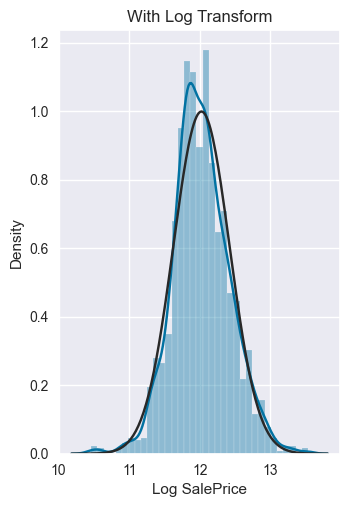

In [22]:
plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [23]:
log_target = np.log(target)

In [24]:
train_f = data7.loc[:train.index.max(), :].copy()
test_f = data7.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()

In [25]:
train_f

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       -0.049717 -0.103719     0.646183    -0.435439   1.040634   
1        0.588360  0.146544    -0.063185     1.906370   0.161526   
2        0.088781  0.457629     0.646183    -0.435439   0.975922   
3       -0.295173  0.136301     0.646183    -0.435439  -1.869638   
4        0.738543  0.922662     1.355551    -0.435439   0.943542   
...           ...       ...          ...          ...        ...   
1455    -0.194659 -0.231508    -0.063185    -0.435439   0.911146   
1456     0.774984  0.767440    -0.063185     0.454875   0.227056   
1457    -0.002863  0.029092     0.646183     2.514892  -0.996100   
1458     0.088781  0.170303    -0.772552     0.454875  -0.696444   
1459     0.389841  0.214215    -0.772552     0.454875  -0.200076   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0         0.896833    1.207310    0.783085   -0.363104  -0.326929  ...   
1        -0.395604   -0.806456    0.892295   -0.363104   0.013451  ...   
2         0.848965    1.135097    0.658017   -0.363104   0.240041  ...   
3        -0.682812   -0.806456    0.386799   -0.363104   0.356896  ...   
4         0.753229    1.427464    0.757965   -0.363104   0.304932  ...   
...            ...         ...         ...         ...        ...  ...   
1455      0.753229   -0.806456   -1.418231   -0.363104   0.660857  ...   
1456      0.178812    1.018363    0.820752    2.350855   0.403357  ...   
1457      1.040437   -0.806456    0.467491   -0.363104   0.616372  ...   
1458      0.561757   -0.806456   -0.105693    3.328676  -3.015461  ...   
1459     -0.922153   -0.806456    0.837304    2.656027  -0.379067  ...   

      SaleType_New  SaleType_None  SaleType_Oth  SaleType_WD  \
0        -0.298629      -0.018512     -0.049029     0.395018   
1        -0.298629      -0.018512     -0.049029     0.395018   
2        -0.298629      -0.018512     -0.049029     0.395018   
3        -0.298629      -0.018512     -0.049029     0.395018   
4        -0.298629      -0.018512     -0.049029     0.395018   
...            ...            ...           ...          ...   
1455     -0.298629      -0.018512     -0.049029     0.395018   
1456     -0.298629      -0.018512     -0.049029     0.395018   
1457     -0.298629      -0.018512     -0.049029     0.395018   
1458     -0.298629      -0.018512     -0.049029     0.395018   
1459     -0.298629      -0.018512     -0.049029     0.395018   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                 -0.263861              -0.064249              -0.09105   
1                 -0.263861              -0.064249              -0.09105   
2                 -0.263861              -0.064249              -0.09105   
3                  3.789876              -0.064249              -0.09105   
4                 -0.263861              -0.064249              -0.09105   
...                     ...                    ...                   ...   
1455              -0.263861              -0.064249              -0.09105   
1456              -0.263861              -0.064249              -0.09105   
1457              -0.263861              -0.064249              -0.09105   
1458              -0.263861              -0.064249              -0.09105   
1459              -0.263861              -0.064249              -0.09105   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                -0.126535              0.463937              -0.302693  
1                -0.126535              0.463937              -0.302693  
2                -0.126535              0.463937              -0.302693  
3                -0.126535             -2.155466              -0.302693  
4                -0.126535              0.463937              -0.302693  
...                    ...                   ...                    ...  
1455             -0.126535              0.463937              -0.302693  
1456             -0.126535

In [26]:
test_f

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0        0.588360  0.521437    -0.772552     0.454875  -0.332070   
1        0.626590  0.923625    -0.063185     0.454875  -0.431241   
2        0.348573  0.862607    -0.772552    -0.435439   0.846305   
3        0.510463  0.222291    -0.063185     0.454875   0.878733   
4       -1.313021 -1.130892     1.355551    -0.435439   0.683917   
...           ...       ...          ...          ...        ...   
1454    -3.472654 -2.993401    -1.481920     1.226101  -0.035461   
1455    -3.472654 -3.036401    -1.481920    -0.435439  -0.035461   
1456     2.728701  1.586172    -0.772552     1.226101  -0.365110   
1457    -0.194659  0.311255    -0.772552    -0.435439   0.683917   
1458     0.348573  0.152052     0.646183    -0.435439   0.716427   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0        -1.113625   -0.806456    0.645381    2.285328  -0.013540  ...   
1        -1.257229    0.981716    0.872896   -0.363104   0.204389  ...   
2         0.657493   -0.806456    0.821176   -0.363104  -0.375170  ...   
3         0.657493    0.354006    0.729700   -0.363104   0.083828  ...   
4         0.370284   -0.806456    0.452577   -0.363104   0.695650  ...   
...            ...         ...         ...         ...        ...  ...   
1454     -0.682812   -0.806456   -1.418231   -0.363104   0.362806  ...   
1455     -0.682812   -0.806456    0.438297   -0.363104   0.031931  ...   
1456      0.561757   -0.806456    0.967505   -0.363104  -3.015461  ...   
1457      0.370284   -0.806456    0.535481   -0.363104   0.390488  ...   
1458      0.466021    0.929317    0.806897   -0.363104  -0.080873  ...   

      SaleType_New  SaleType_None  SaleType_Oth  SaleType_WD  \
0        -0.298629      -0.018512     -0.049029     0.395018   
1        -0.298629      -0.018512     -0.049029     0.395018   
2        -0.298629      -0.018512     -0.049029     0.395018   
3        -0.298629      -0.018512     -0.049029     0.395018   
4        -0.298629      -0.018512     -0.049029     0.395018   
...            ...            ...           ...          ...   
1454     -0.298629      -0.018512     -0.049029     0.395018   
1455     -0.298629      -0.018512     -0.049029     0.395018   
1456     -0.298629      -0.018512     -0.049029     0.395018   
1457     -0.298629      -0.018512     -0.049029     0.395018   
1458     -0.298629      -0.018512     -0.049029     0.395018   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                 -0.263861              -0.064249              -0.09105   
1                 -0.263861              -0.064249              -0.09105   
2                 -0.263861              -0.064249              -0.09105   
3                 -0.263861              -0.064249              -0.09105   
4                 -0.263861              -0.064249              -0.09105   
...                     ...                    ...                   ...   
1454              -0.263861              -0.064249              -0.09105   
1455               3.789876              -0.064249              -0.09105   
1456               3.789876              -0.064249              -0.09105   
1457              -0.263861              -0.064249              -0.09105   
1458              -0.263861              -0.064249              -0.09105   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                -0.126535              0.463937              -0.302693  
1                -0.126535              0.463937              -0.302693  
2                -0.126535              0.463937              -0.302693  
3                -0.126535              0.463937              -0.302693  
4                -0.126535              0.463937              -0.302693  
...                    ...                   ...                    ...  
1454             -0.126535              0.463937              -0.302693  
1455             -0.126535

In [26]:
setup(data=pd.concat([train_f, log_target], axis=1), target='SalePrice')

In [27]:
bestmodel = compare_models(include)

In [28]:
tuned_model = tune_model(bestmodel, n_iter=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


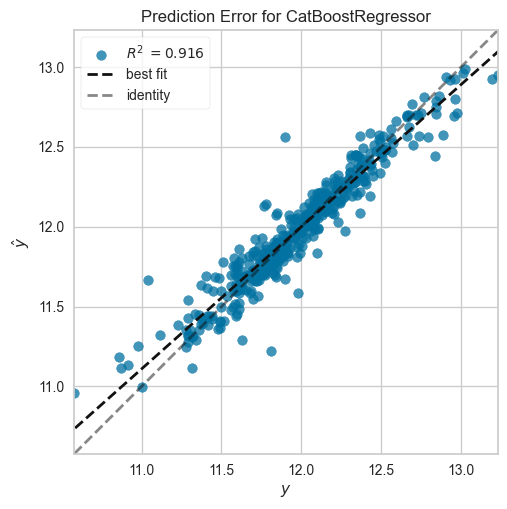

In [29]:
plot_model(tuned_model,plot='error')

In [30]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [31]:
final_model = finalize_model(tuned_model)

In [32]:
prediction = final_model.predict(test_f)
prediction

array([11.77947635, 11.97403515, 12.10792701, ..., 11.96645968,
       11.63657048, 12.29870618])

In [34]:
np.exp(prediction)

array([130545.40113217, 158583.27828131, 181303.37413893, ...,
       157386.47515294, 113161.40945186, 219411.92633512])

In [36]:
sample_submission['SalePrice']=np.exp(prediction)

In [38]:
sample_submission.to_csv('submission4.csv',index=False)

In [71]:
kf = KFold(n_splits=10)

In [68]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        
        'max_features': trial.suggest_categorical('max_features', ['auto','sqrt','log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True,False])
        
    }

    model = ExtraTreesRegressor(n_jobs=-1, **params)
    score = cross_val_score(model, train_f,log_target, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score  # minimize RMS

In [69]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-05-28 14:53:28,839] A new study created in memory with name: no-name-9d8316bb-e10e-4100-a94c-7bc6ca05169b
[I 2025-05-28 14:53:34,413] Trial 0 finished with value: 0.22718124759150243 and parameters: {'n_estimators': 390, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.22718124759150243.
[I 2025-05-28 14:54:37,217] Trial 1 finished with value: 0.13592531513833145 and parameters: {'n_estimators': 931, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': False}. Best is trial 1 with value: 0.13592531513833145.
[I 2025-05-28 14:54:52,433] Trial 2 finished with value: 0.14020158263953578 and parameters: {'n_estimators': 278, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'auto', 'bootstrap': False}. Best is trial 1 with value: 0.13592531513833145.
[I 2025-05-28 14:55:01,185] Trial 3 finished with value: 0.2199947

In [70]:
study.best_params

{'n_estimators': 660,
 'max_depth': 39,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': False}

In [ ]:
print(log_target.describe())  # Check if values are too similar or constant


In [71]:
Br_param = {'n_iter': 467,
 'tol': 7.350954069359141,
 'alpha_1': 4.430153584389162e-05,
 'alpha_2': 9.116812602114976,
 'lambda_1': 9.000179449421317,
 'lambda_2': 0.00022554913303240588}


LGBMR_param = {'n_estimators': 818,
 'max_depth': 3,
 'learning_rate': 0.04259106472523809,
 'num_leaves': 134,
 'min_child_samples': 15,
 'subsample': 0.9513668191949727,
 'colsample_bytree': 0.9050118614316467,
 'reg_alpha': 2.6037269444401766e-07,
 'reg_lambda': 0.0003788603929097712}

catboost_params = {'iterations': 539,
 'depth': 5,
 'learning_rate': 0.04222892280282932,
 'l2_leaf_reg': 1.818381565653919,
 'bagging_temperature': 0.9563384315991034,
 'random_strength': 3.92508448555641,
 'border_count': 95}

grad_params = {'n_estimators': 632,
 'max_depth': 7,
 'learning_rate': 0.019205523957623115,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'subsample': 0.6935424154165891,
 'max_features': 'sqrt'}

extra_params = {'n_estimators': 660,
 'max_depth': 39,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': False}

In [73]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "Br": BayesianRidge(**Br_param),
    "lightgbm": LGBMRegressor(**LGBMR_param),
    "ridge": GradientBoostingRegressor(**grad_params),
    "et": ExtraTreesRegressor(**extra_params)
}

In [75]:
for name, model in models.items():
    model.fit(train_f, log_target)
    print(name + " trained.")

catboost trained.
Br trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4266
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 228
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [76]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_f, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4169
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 226
[LightGBM] [Info] Start training from score 12.026856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [77]:
results

{'catboost': array([1.11743623, 1.09982783, 1.11108036, 1.15657489, 1.16050487,
        1.10700851, 1.12372705, 1.10385898, 1.13288642, 1.13234731]),
 'Br': array([1.12330086, 1.10411098, 1.12461416, 1.16724599, 1.15390535,
        1.13043393, 1.12583115, 1.10241698, 1.18778534, 1.13268516]),
 'lightgbm': array([1.13268723, 1.10092664, 1.11082037, 1.16524808, 1.17643697,
        1.11313673, 1.12676502, 1.10823045, 1.12920642, 1.14105403]),
 'ridge': array([1.11956842, 1.1041789 , 1.11241921, 1.16050099, 1.16048064,
        1.10993418, 1.11967374, 1.10287951, 1.13602325, 1.12869554]),
 'et': array([1.1289136 , 1.11368678, 1.14335009, 1.1807465 , 1.20073682,
        1.12445903, 1.14186563, 1.1213181 , 1.13637075, 1.15441318])}

In [82]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1245252450678447
0.020070765983792718
----------
Br
1.1352329915169168
0.02560031350851075
----------
lightgbm
1.1304511947484144
0.023470606088746352
----------
ridge
1.1254354378552214
0.0200460222687414
----------
et
1.1445860476845624
0.026039131565345222


In [83]:
final_predictions = (
    0.4 * np.exp(models['catboost'].predict(test_f)) +
    0.1 * np.exp(models['Br'].predict(test_f)) +
    0.2 * np.exp(models['lightgbm'].predict(test_f)) +
    0.2 * np.exp(models['ridge'].predict(test_f)) +
    0.1 * np.exp(models['et'].predict(test_f))
)

In [84]:
final_predictions

array([123800.84402773, 157037.91765305, 181828.91764653, ...,
       159081.57492261, 117091.39324067, 223942.97572726])

In [85]:
submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

Id      SalePrice
0     1461  123800.844028
1     1462  157037.917653
2     1463  181828.917647
3     1464  191999.019317
4     1465  188146.853302
...    ...            ...
1454  2915   83814.197054
1455  2916   79822.837979
1456  2917  159081.574923
1457  2918  117091.393241
1458  2919  223942.975727

[1459 rows x 2 columns]

In [86]:
submission.to_csv('submission5.csv', index=False)